<a href="https://colab.research.google.com/github/chaiminwoo0223/Deep-Learning/blob/main/06%20-%20MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torchvision
from torchvision import transforms, datasets 
%matplotlib inline

In [2]:
if torch.cuda.is_available(): 
    DEVICE = torch.device('cuda:0') # GPU가 사용 가능한 경우에는 device를 GPU로 설정
else:
    DEVICE = torch.device('cpu')    # GPU가 사용 불가능한 경우에는 device를 CPU로 설정
print(DEVICE)

cuda:0


# 데이터 다운로드

In [3]:
train_dataset = datasets.MNIST(
    root = "../data/MNIST", # 다운받을 경로
    train = True,           # 학습 데이터
    download = True,        # 다운로드
    transform = transforms.ToTensor() # 전처리(텐서로 변환)
)

test_dataset = datasets.MNIST(
    root = "../data/MNIST", # 다운받을 경로
    train = False,          # 학습 데이터
    download = True,        # 다운로드
    transform = transforms.ToTensor() # 전처리(텐서로 변환)
)

100%|██████████| 9912422/9912422 [00:00<00:00, 104586143.41it/s]


Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 103182022.00it/s]


Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23974470.04it/s]


Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22924824.03it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



# DataLoader

In [4]:
BATCH_SIZE = 32

# train_loader
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, # 사용할 데이터셋
    batch_size = BATCH_SIZE, # 몇 개씩 잘라서 넣어줄지
    shuffle = True           # 데이터를 섞을지
)
# test_loader
test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset,  # 사용할 데이터셋
    batch_size = BATCH_SIZE, # 몇 개씩 잘라서 넣어줄지
    shuffle = False          # 데이터를 섞을지
)

# MNIST 데이터

In [5]:
images, labels = next(iter(train_loader))
print(images.size(), images.type())
print(labels.size(), labels.type())

torch.Size([32, 1, 28, 28]) torch.FloatTensor
torch.Size([32]) torch.LongTensor


Text(0.5, 1.0, '0')

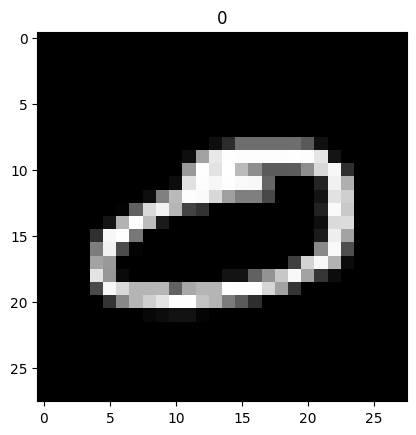

In [6]:
img = np.squeeze(images[3].numpy())

plt.imshow(img, cmap='gray')
plt.title(str(labels[3].item()))

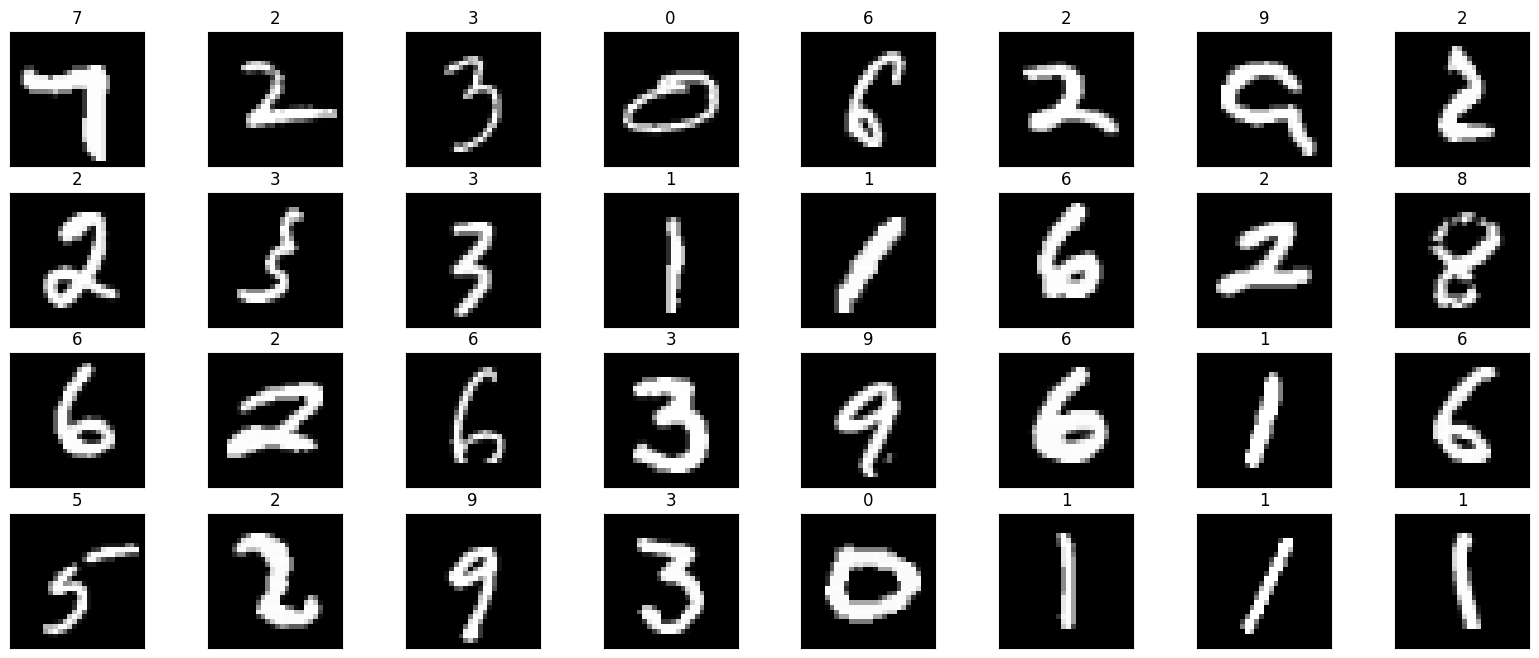

In [7]:
fig = plt.figure(figsize=(20,8))
for idx in np.arange(BATCH_SIZE):
    ax = fig.add_subplot(4, int(BATCH_SIZE/4), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

In [8]:
def imshow(img):
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

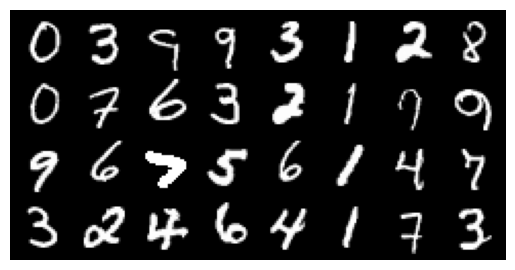

In [9]:
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))

In [10]:
npimg = torchvision.utils.make_grid(images).numpy()
npimg.shape

(3, 122, 242)

# CNN

In [11]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28,512)
        self.fc2 = nn.Linear(512,1024)
        self.fc3 = nn.Linear(1024,512)
        self.fc4 = nn.Linear(512,256)
        self.fc5 = nn.Linear(256,10)

    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.log_softmax(x, dim=1)
        return x

In [12]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight.data)

model = MLP().to(DEVICE)
model.apply(weight_init)

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=10, bias=True)
)

In [13]:
# 최적화 함수
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#손실 함수
loss_fn = nn.CrossEntropyLoss()

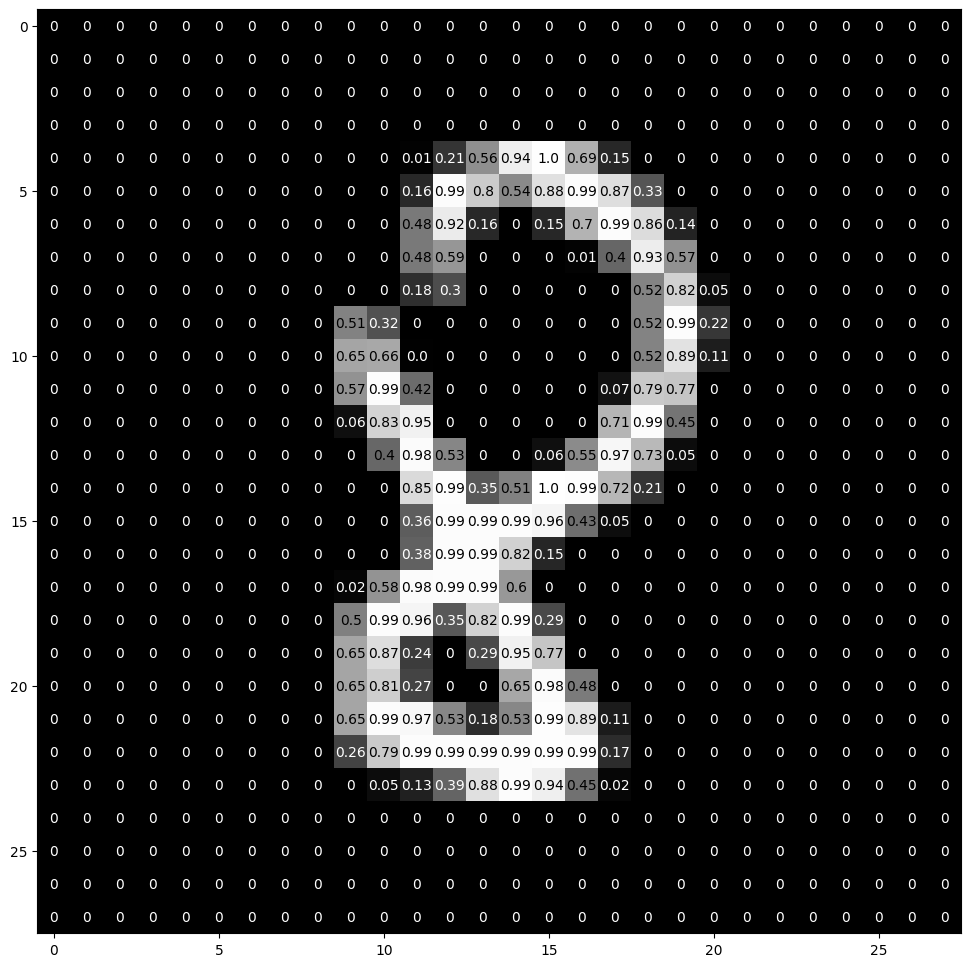

In [14]:
from pathlib import WindowsPath

idx = 7
img = np.squeeze(images[idx].numpy())

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max() / 2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y], 2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment = 'center',
                    color='white' if img[x][y]<thresh else 'black')

## Train

In [15]:
def train(model, train_loader, optimizer):
    model.train()
    train_loss = 0
    correct = 0

    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss_fn(output, label).item()
        prediction = output.max(1, keepdim=True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100 * correct / len(train_loader.dataset)
    return train_loss, train_accuracy

## Test

In [16]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += loss_fn(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [17]:
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)

    print("[EPOCH: {}], \tTrain_Loss: {:.4f}, \tTrain_Accuracy: {:.2f} %, \tTest_Loss: {:.4f}, \tTest_Accuracy: {:.2f} %".format(
        epoch, train_loss, train_accuracy, test_loss, test_accuracy
    ))

[EPOCH: 1], 	Train_Loss: 0.0151, 	Train_Accuracy: 87.96 %, 	Test_Loss: 0.0103, 	Test_Accuracy: 91.81 %
[EPOCH: 2], 	Train_Loss: 0.0103, 	Train_Accuracy: 91.76 %, 	Test_Loss: 0.0120, 	Test_Accuracy: 91.47 %
[EPOCH: 3], 	Train_Loss: 0.0088, 	Train_Accuracy: 93.01 %, 	Test_Loss: 0.0096, 	Test_Accuracy: 92.46 %
[EPOCH: 4], 	Train_Loss: 0.0087, 	Train_Accuracy: 93.06 %, 	Test_Loss: 0.0078, 	Test_Accuracy: 94.08 %
[EPOCH: 5], 	Train_Loss: 0.0088, 	Train_Accuracy: 93.15 %, 	Test_Loss: 0.0090, 	Test_Accuracy: 93.28 %
[EPOCH: 6], 	Train_Loss: 0.0077, 	Train_Accuracy: 93.93 %, 	Test_Loss: 0.0085, 	Test_Accuracy: 93.26 %
[EPOCH: 7], 	Train_Loss: 0.0074, 	Train_Accuracy: 94.10 %, 	Test_Loss: 0.0074, 	Test_Accuracy: 94.39 %
[EPOCH: 8], 	Train_Loss: 0.0070, 	Train_Accuracy: 94.36 %, 	Test_Loss: 0.0076, 	Test_Accuracy: 94.16 %
[EPOCH: 9], 	Train_Loss: 0.0072, 	Train_Accuracy: 94.19 %, 	Test_Loss: 0.0072, 	Test_Accuracy: 94.38 %
[EPOCH: 10], 	Train_Loss: 0.0070, 	Train_Accuracy: 94.58 %, 	Test_Loss: 0

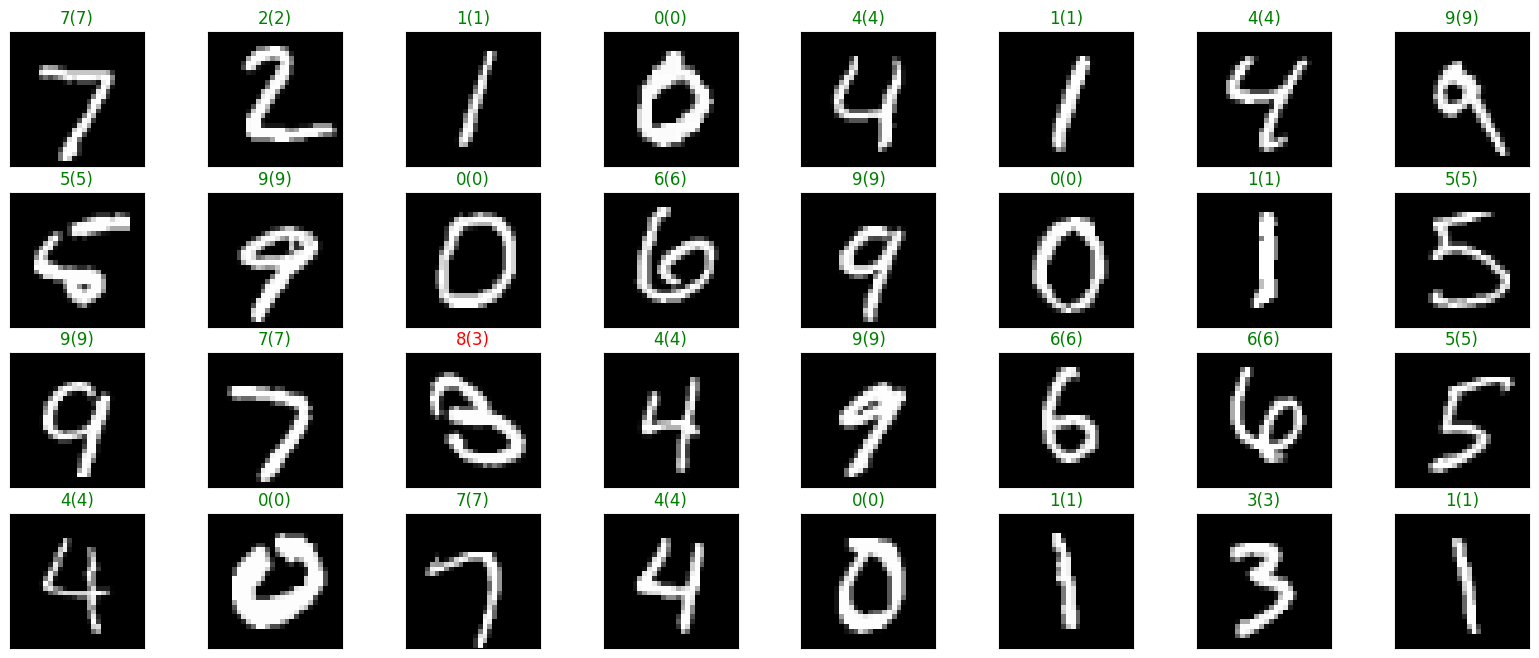

In [18]:
images, labels = next(iter(test_loader))
images = images.to(DEVICE)
labels = labels.to(DEVICE)

output = model(images)
_, preds = torch.max(output, 1)
images = images.cpu().numpy()

fig = plt.figure(figsize=(20,8))
for idx in np.arange(BATCH_SIZE):
    ax = fig.add_subplot(4, int(BATCH_SIZE/4), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{}({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))